# Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dotenv import load_dotenv
# from sdv.single_table import GaussianCopulaSynthesizer
# from sdv.metadata import Metadata
#Set plot style
plt.style.use("seaborn-v0_8")


# Connect to Neon DB &  Load data

In [2]:
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")

engine = create_engine(DB_URL)

query = """
SELECT "timestamp", "part_id", "reading"
FROM "catdc_data_feed"
WHERE "state"='RUNNING';
"""


df_long = pd.read_sql(query, engine)

df_train = df_long.pivot_table(index="timestamp", columns="part_id", values="reading", aggfunc="mean")

df_train.columns = [f"Axis #{i}" for i in df_train.columns]
df_train.reset_index(inplace=True)
df_train.rename(columns={"timestamp": "Time"}, inplace=True)

#fill missing values
df_train.fillna(0, inplace=True)

#convert time to datetime

df_train["Time"] = pd.to_datetime(df_train["Time"])



axis_cols = [col for col in df_train.columns if col.startswith("Axis #")]


#Previews first 5 rows

df_train.head()



,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-17 12:18:25.472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-17 12:18:27.348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-17 12:18:29.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-17 12:18:31.117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Fills missing values NaN
df_train.fillna(0, inplace=True)


#Filter out the rows where all axis are zero
axis_cols = [col for col in df_train.columns if col.startswith("Axis #")]
df_train_nonzero = df_train[(df_train[axis_cols] != 0).any(axis=1)]


# Filtered df for regression, normalization and residuals
df_train = df_train_nonzero.copy()

#Keeps a copy of the full df
df_train_full = df_train_nonzero.copy()

df_train.head()

,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
30,2022-10-17 12:19:20.136,0.0,3.0,4.0,0.0,1.0,1.0,4.0,0.0
31,2022-10-17 12:19:22.005,7.0,30.0,17.0,5.0,6.0,5.0,0.0,0.0
32,2022-10-17 12:19:27.952,0.0,11.0,3.0,2.0,4.0,5.0,4.0,0.0
33,2022-10-17 12:19:29.911,2.0,20.0,11.0,2.0,4.0,1.0,0.0,0.0
34,2022-10-17 12:19:31.969,4.0,2.0,5.0,1.0,1.0,1.0,0.0,0.0


# Normalize data (min-max)

In [4]:
scaler_minmax = MinMaxScaler()
df_norm = df_train.copy()
df_norm[axis_cols] = scaler_minmax.fit_transform(df_train[axis_cols])

df_norm.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
30,2022-10-17 12:19:20.136,0.000000,0.06,0.097561,0.000000,0.047619,0.052632,0.5,0.0
31,2022-10-17 12:19:22.005,0.304348,0.60,0.414634,0.333333,0.285714,0.263158,0.0,0.0
32,2022-10-17 12:19:27.952,0.000000,0.22,0.073171,0.133333,0.190476,0.263158,0.5,0.0
33,2022-10-17 12:19:29.911,0.086957,0.40,0.268293,0.133333,0.190476,0.052632,0.0,0.0
34,2022-10-17 12:19:31.969,0.173913,0.04,0.121951,0.066667,0.047619,0.052632,0.0,0.0


# Standardize (Z-scores)


In [5]:
scaler_std = StandardScaler()

df_std = df_train.copy()
df_std[axis_cols] = scaler_std.fit_transform(df_train[axis_cols])

#scale time to mins\

df_std["time_min"] = (df_std["Time"] - df_std["Time"].min()).dt.total_seconds() / 60
df_std.head()


,Time,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8,time_min
30,2022-10-17 12:19:20.136,-0.599984,-0.887572,-0.624537,-0.793293,-0.621436,-0.248033,0.519391,-0.280185,0.000000
31,2022-10-17 12:19:22.005,1.573688,2.434697,1.450786,1.541463,1.126192,1.215521,-0.770979,-0.280185,0.031150
32,2022-10-17 12:19:27.952,-0.599984,0.096804,-0.784177,0.140610,0.427141,1.215521,0.519391,-0.280185,0.130267
33,2022-10-17 12:19:29.911,0.021065,1.204227,0.492945,0.140610,0.427141,-0.248033,-0.770979,-0.280185,0.162917
34,2022-10-17 12:19:31.969,0.642114,-1.010619,-0.464897,-0.326342,-0.621436,-0.248033,-0.770979,-0.280185,0.197217


# Regression Models (Time > Axis

Axis #1: slope = -0.00041, intercept = 0.04143


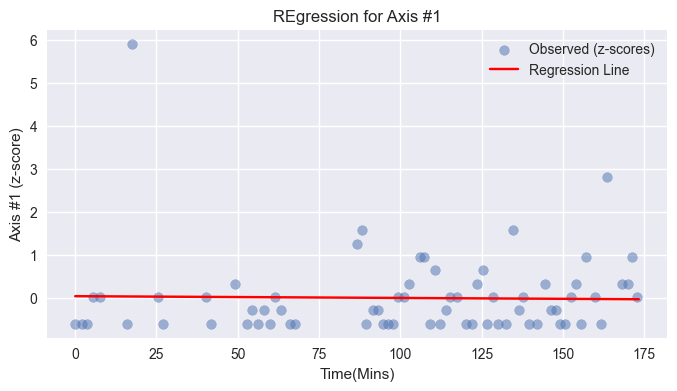

Axis #2: slope = -0.00008, intercept = 0.00803


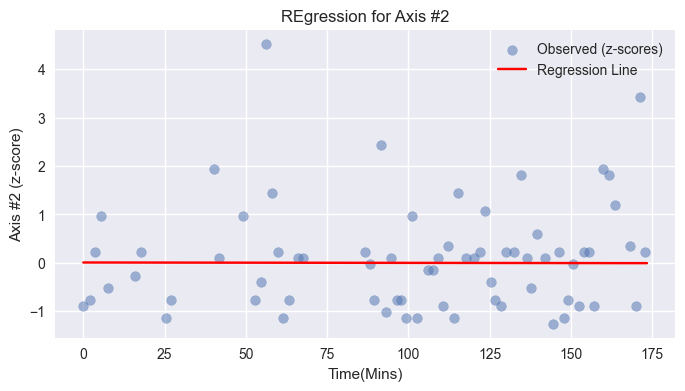

Axis #3: slope = -0.00018, intercept = 0.01866


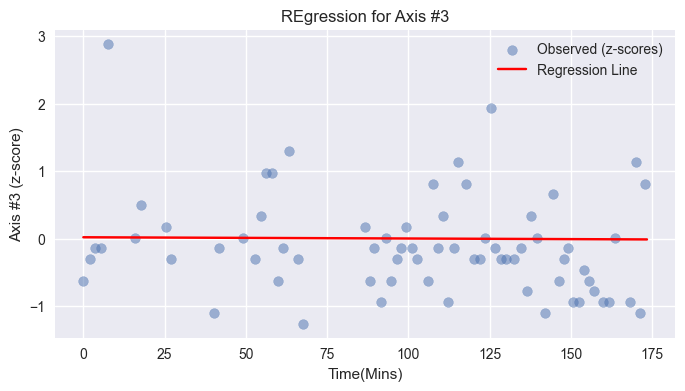

Axis #4: slope = -0.00026, intercept = 0.02589


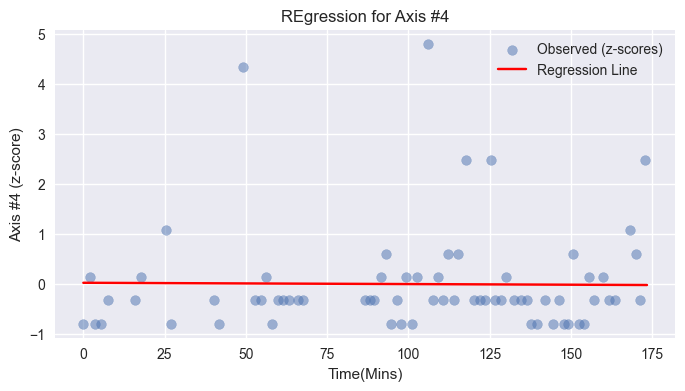

Axis #5: slope = 0.00034, intercept = -0.03449


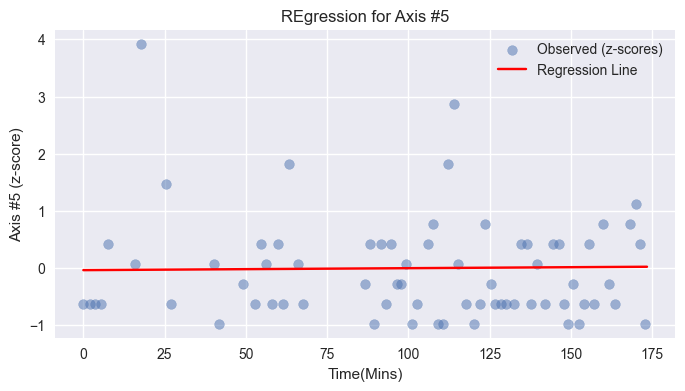

Axis #6: slope = 0.00004, intercept = -0.00390


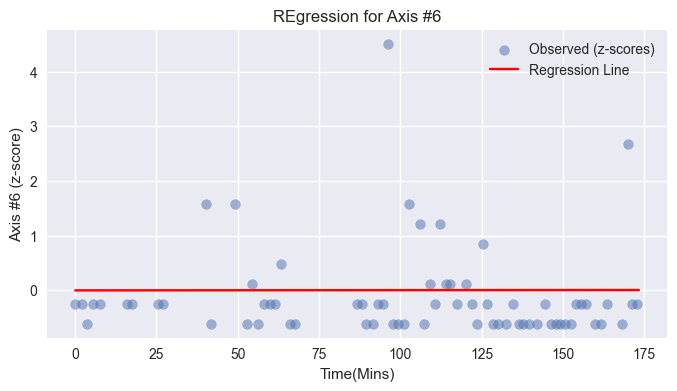

Axis #7: slope = -0.00016, intercept = 0.01588


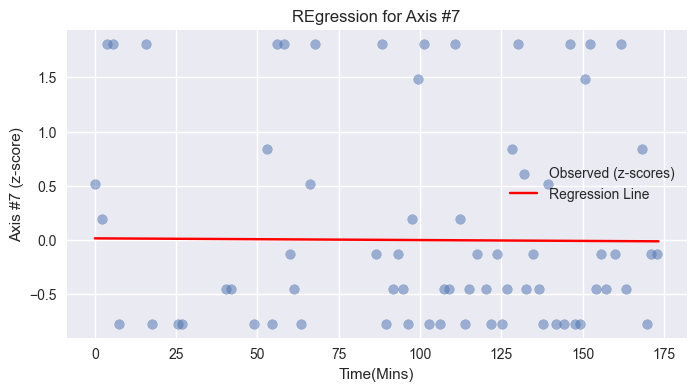

Axis #8: slope = -0.00006, intercept = 0.00654


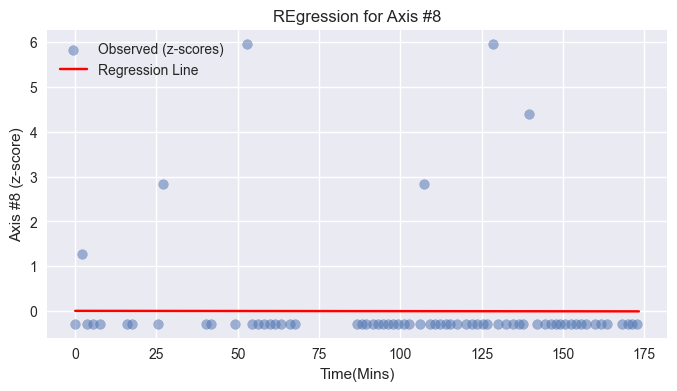

In [6]:
#Try plotting throyugh the standrize score

models = {}
residuals = {}

for axis in axis_cols:
    x = df_std[["time_min"]].values
    y = df_std[axis].values

    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)

    models[axis] = model
    residuals[axis] = y - y_pred



    #Identify the slope and interfcept
    print(f"{axis}: slope = {model.coef_[0]:.5f}, intercept = {model.intercept_:.5f}")

    #Reduces  the number of rows plotted in this case every 30th row
    df_plot = df_std.iloc[::30]

    plt.figure(figsize=(8,4))
    plt.scatter(df_plot["time_min"], df_plot[axis], alpha=0.5, label="Observed (z-scores)" )
    plt.plot(df_std["time_min"], y_pred, color="red", label="Regression Line")
    plt.title(f"REgression for {axis}")
    plt.xlabel("Time(Mins)")
    plt.ylabel(f"{axis} (z-score)")
    plt.legend()
    plt.show()


# Generate Synthetic Testing Data

In [7]:
# We must define the synthetic time range (1 min interveals)
#Uses the standardized data for synthetic creation
start_time = df_train["Time"].min()
end_time = df_train["Time"].max() + pd.Timedelta(minutes = 30)
time_index = pd.date_range(start=start_time, end=end_time, freq="1min")



df_synth = pd.DataFrame({"Time": time_index})

df_synth["time_min"] = (df_synth["Time"] - df_train["Time"].min()).dt.total_seconds() /60

# Create the synthetic readings
for axis in axis_cols:
    model = models[axis]
    y_synth = model.predict(df_synth[["time_min"]].values)


    #To add realistic deviations we use the training residuals
    train_res = np.array(residuals[axis])
    repeats = int(np.ceil(len(df_synth)/ len(train_res)))
    synthetic_residuals = np.tile(train_res, repeats)[:len(df_synth)]
    df_synth[axis] = y_synth + synthetic_residuals

print(df_synth.head())





                     Time  time_min   Axis #1   Axis #2   Axis #3   Axis #4  \
0 2022-10-17 12:19:20.136       0.0 -0.599984 -0.887572 -0.624537 -0.793293   
1 2022-10-17 12:20:20.136       1.0  1.573291  2.434620  1.450607  1.541215   
2 2022-10-17 12:21:20.136       2.0 -0.600750  0.096656 -0.784523  0.140131   
3 2022-10-17 12:22:20.136       3.0  0.019902  1.204002  0.492421  0.139883   
4 2022-10-17 12:23:20.136       4.0  0.640555 -1.010921 -0.465599 -0.327316   

    Axis #5   Axis #6   Axis #7   Axis #8  
0 -0.621436 -0.248033  0.519391 -0.280185  
1  1.126523  1.215558 -0.771131 -0.280248  
2  0.427779  1.215593  0.519098 -0.280306  
3  0.428110 -0.247923 -0.771425 -0.280368  
4 -0.620138 -0.247886 -0.771576 -0.280431  


# Residual on Syntehtic Data


In [8]:
residuals_synth = {}

for axis in axis_cols:

    y_pred = models[axis].predict(df_synth[["time_min"]].values)
    residuals_synth[axis] = df_synth[axis] - y_pred

for axis in axis_cols[:3]:
    print(f"{axis} residuals (first 10):\n", residuals_synth[axis][:10])

Axis #1 residuals (first 10):
 0   -0.641416
1    1.532268
2   -0.641363
3   -0.020300
4    0.600763
5   -0.641322
6   -0.641308
7   -0.641295
8   -0.330757
9    0.600830
Name: Axis #1, dtype: float64
Axis #2 residuals (first 10):
 0   -0.895605
1    2.426666
2    0.088781
3    1.196207
4   -1.018637
5    0.211836
6   -0.157302
7    0.088794
8   -0.649485
9   -0.403389
Name: Axis #2, dtype: float64
Axis #3 residuals (first 10):
 0   -0.643200
1    1.432129
2   -0.802816
3    0.474312
4   -0.483523
5   -0.802798
6   -1.122072
7   -0.323865
8   -0.962420
9    0.314708
Name: Axis #3, dtype: float64


# Residual Analysis

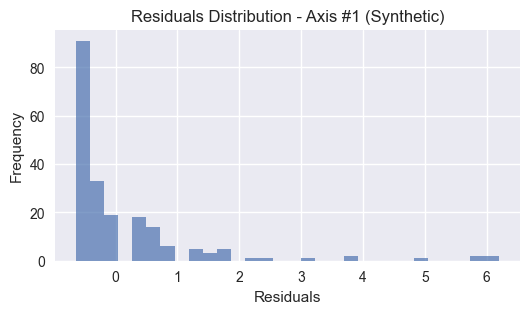

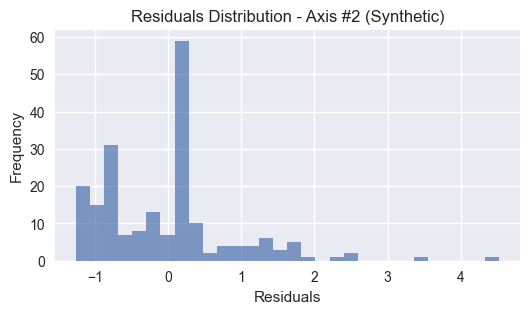

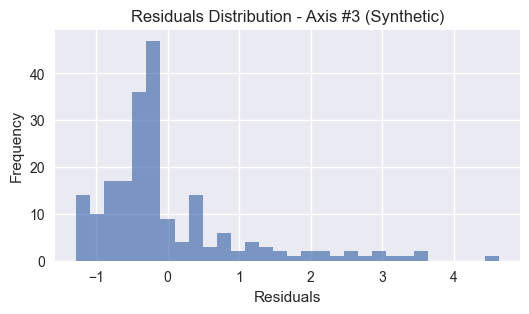

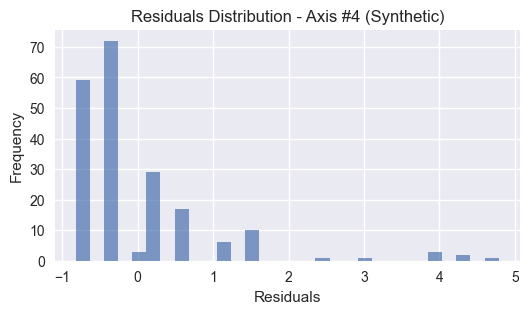

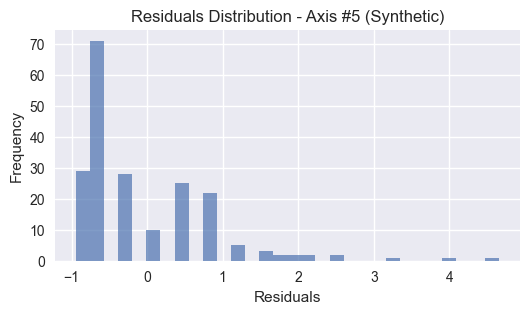

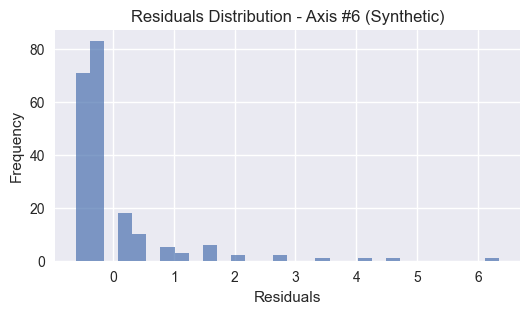

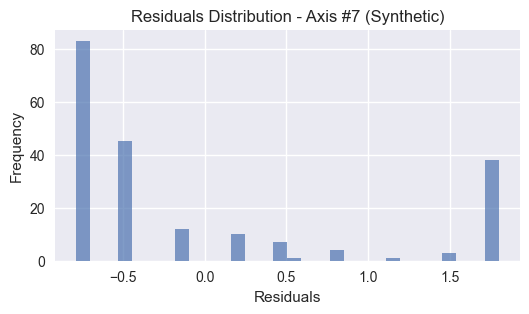

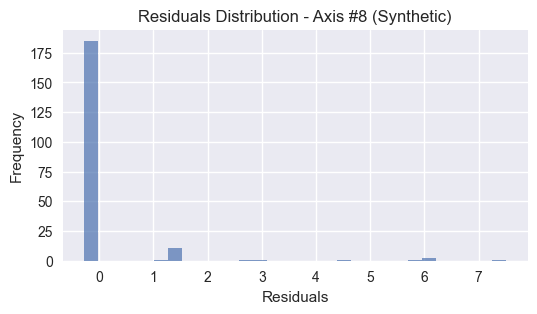

In [9]:
for axis in axis_cols:

    res = residuals_synth[axis]
    plt.figure(figsize=(6,3))

    if np.all(res == 0):
        plt.bar(0,len(res), width=0.5, alpha=0.7)
        plt.xticks([0])
    else:
        plt.hist(res, bins=30, alpha=0.7)


    plt.title(f"Residuals Distribution - {axis} (Synthetic)")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

# Define Min Max

In [10]:
thresholds = {}
T_seconds = 5 #the number of miminmum contious time for alert or error

for axis in axis_cols:
    res = residuals_synth[axis]


    minC = np.percentile(res, 80) #80th percentile deviation sends alert
    maxC = np.percentile(res, 90) #90th percentile deviation sends error

    thresholds[axis] = {"MinC": minC, "MaxC": maxC, "T": T_seconds}

thresholds

{'Axis #1': {'MinC': np.float64(0.6008403127802602),
  'MaxC': np.float64(1.2239603366444),
  'T': 5},
 'Axis #2': {'MinC': np.float64(0.3351139020445033),
  'MaxC': np.float64(1.1975846580524936),
  'T': 5},
 'Axis #3': {'MinC': np.float64(0.4761417005262064),
  'MaxC': np.float64(1.337210029697935),
  'T': 5},
 'Axis #4': {'MinC': np.float64(0.3044532531687153),
  'MaxC': np.float64(1.0518707092421662),
  'T': 5},
 'Axis #5': {'MinC': np.float64(0.5988536375131842),
  'MaxC': np.float64(0.8105887015247812),
  'T': 5},
 'Axis #6': {'MinC': np.float64(0.1215777340395407),
  'MaxC': np.float64(0.8529058285574059),
  'T': 5},
 'Axis #7': {'MinC': np.float64(1.2802163429981923),
  'MaxC': np.float64(1.7947444671169022),
  'T': 5},
 'Axis #8': {'MinC': np.float64(-0.28558592849609005),
  'MaxC': np.float64(-0.2854940076753717),
  'T': 5}}

# Detect Alerts  & Errors

In [11]:

alerts = []

def find_periods(mask):
        periods = []
        start_idx = None
        for i, val in enumerate(mask):
            if val and start_idx is None:
                start_idx = i
            elif not val and start_idx is not None:
                duration = df_synth["time_min"].iloc[i-1] - df_synth["time_min"].iloc[start_idx]
                if duration >=T_seconds:
                    periods.append((df_synth["Time"].iloc[start_idx], df_synth["Time"].iloc[i-1]))
                start_idx = None
        if start_idx is not None:
            duration = (df_synth["time_min"].iloc[-1] - df_synth["time_min"].iloc[start_idx]) * 60
            if duration >= T_seconds:
                    periods.append((df_synth["Time"].iloc[start_idx], df_synth["Time"].iloc[-1]))

        return periods


for axis in axis_cols:

    res = residuals_synth[axis]
    MinC = thresholds[axis]["MinC"]
    MaxC = thresholds[axis]["MaxC"]
    T = thresholds[axis]["T"]


    above_min = res > MinC
    above_max = res > MaxC




    alerts += [(axis, "ALERT", start, end) for start, end in find_periods(above_min)]
    alerts += [(axis, "ERROR", start, end) for start, end in find_periods(above_max)]

#Convert to dataframe
alerts_df = pd.DataFrame(alerts, columns=["Axis", "Type", "Start Time", "End Time"])
alerts_df.head()




,Axis,Type,Start Time,End Time
0,Axis #8,ALERT,2022-10-17 15:19:20.136,2022-10-17 15:42:20.136
1,Axis #8,ERROR,2022-10-17 15:41:20.136,2022-10-17 15:42:20.136


# Overlay alerts or Errors on plot

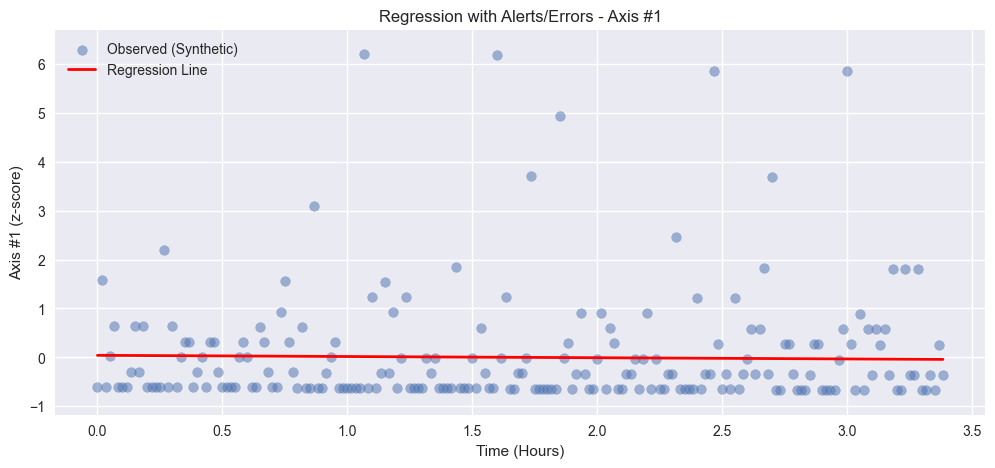

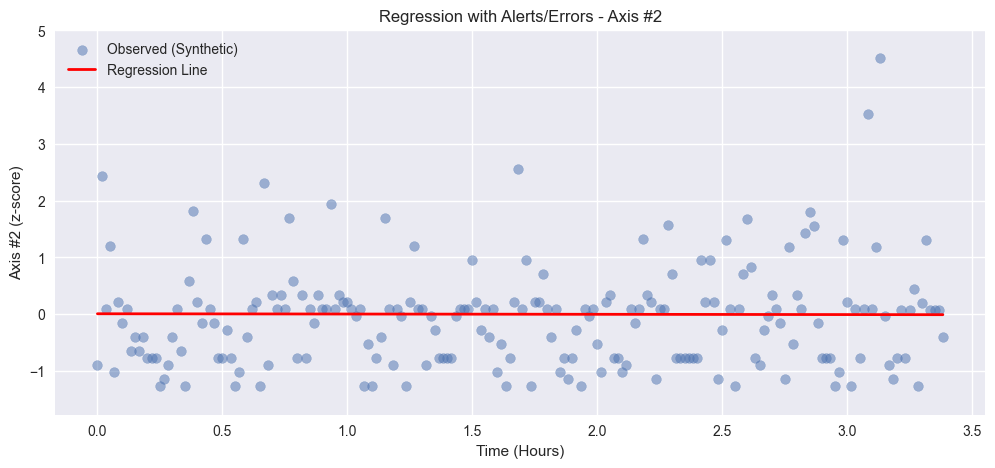

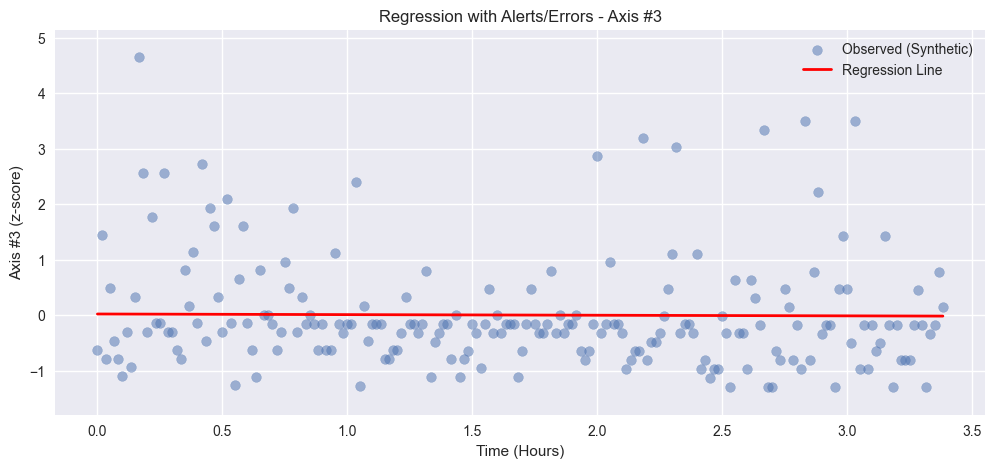

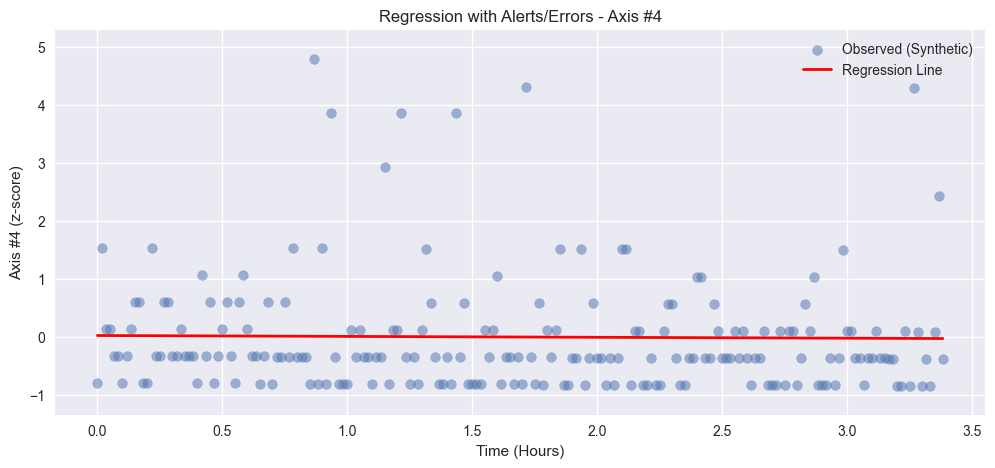

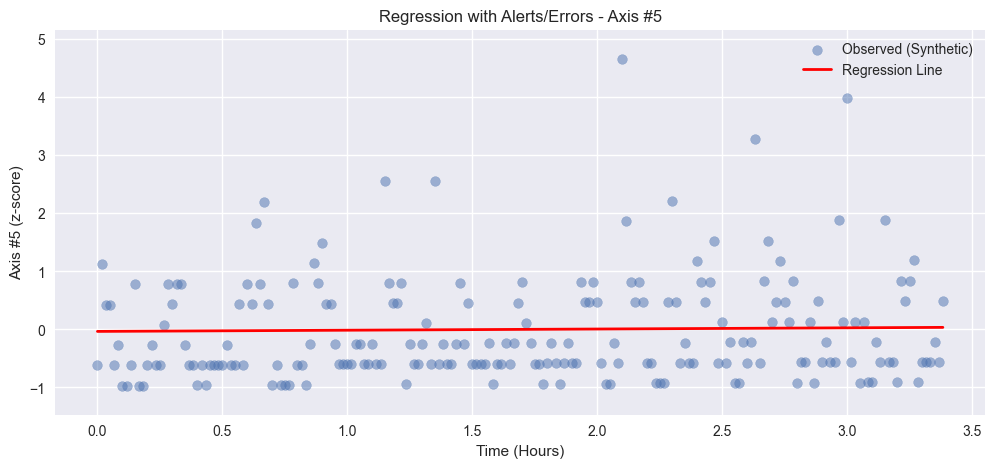

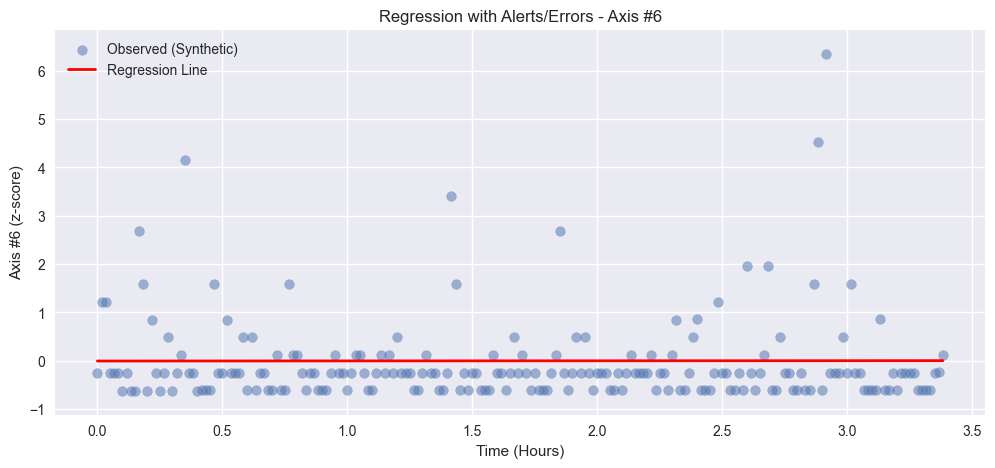

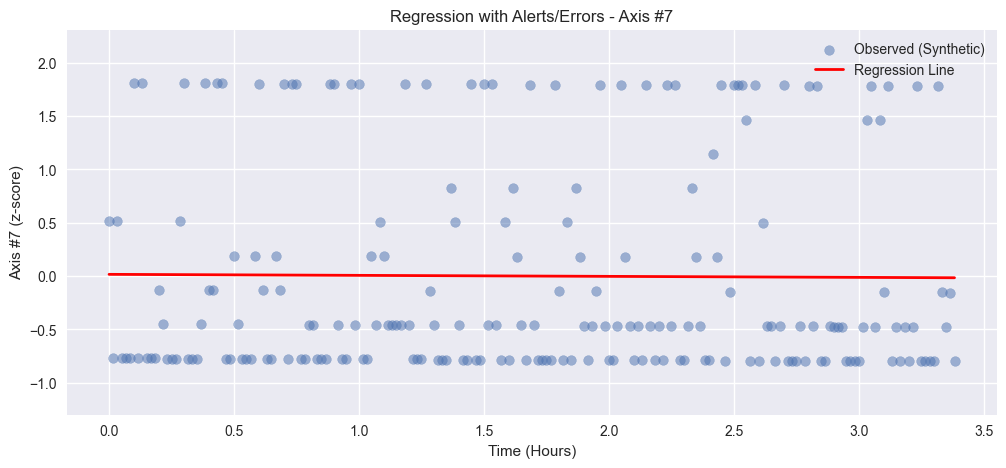

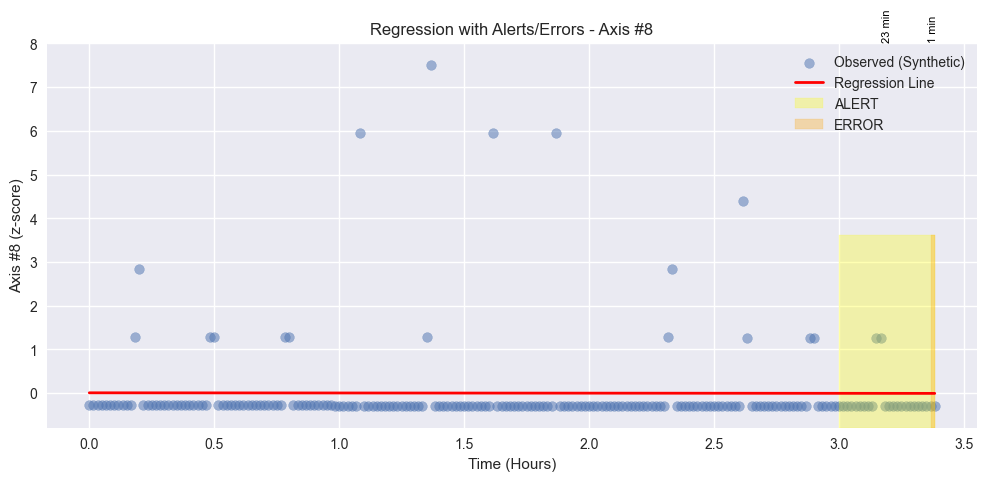

In [12]:

for axis in axis_cols:
    x_test = df_synth["time_min"] / 60  # minutes → hours
    y_pred = models[axis].predict(df_synth["time_min"].values.reshape(-1,1))

    plt.figure(figsize=(12,5))
    plt.scatter(x_test, df_synth[axis], alpha=0.5, label="Observed (Synthetic)")
    plt.plot(x_test, y_pred, color="red", linewidth=2, label="Regression Line")

    used_labels = set()
    ymin, ymax = df_synth[axis].min() - 0.5, df_synth[axis].max() + 0.5


    for _, row in alerts_df[alerts_df["Axis"]==axis].iterrows():
        start = (row["Start Time"] - df_train["Time"].min()).total_seconds() / 60 / 60
        end = (row["End Time"] - df_train["Time"].min()).total_seconds() / 60 / 60
        duration_min = (row["End Time"] - row["Start Time"]).total_seconds() / 60

        if row["Type"] == "ERROR":
            plt.axvspan(start, end, ymin=0.0, ymax=0.5, color="orange", alpha=0.3,
                        label="ERROR" if "ERROR" not in used_labels else None)
            used_labels.add("ERROR")
        else:
            plt.axvspan(start, end, ymin=0.0, ymax=0.5, color="yellow", alpha=0.3,
                        label="ALERT" if "ALERT" not in used_labels else None)
            used_labels.add("ALERT")


        plt.text((start+end)/2, ymax, f"{int(duration_min)} min",
                 color="black", ha="center", va="bottom", fontsize=8, rotation=90)

    plt.ylim(ymin, ymax)
    plt.title(f"Regression with Alerts/Errors - {axis}")
    plt.xlabel("Time (Hours)")
    plt.ylabel(f"{axis} (z-score)")
    plt.legend()
    plt.show()


# Save Results

In [13]:
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index")
thresholds_df.to_csv("data/results_thresholds.csv", index_label="Axis")

alerts_df.to_csv("data/results_detected_events.csv", index=False)

print("Results saved in the data folder!")

Results saved in the data folder!
